In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.core.composition import OneOf
import glob
import os

In [2]:
# 경로 설정

data_path = '/workspace/#Ub370#Uc774#Ud130/Data'

img_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/img/train/'
img_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/img/val/'

json_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/label/train/'
json_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/label/val/'

segment_path_train = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/train/'
segment_path_val = '/workspace/#Ub370#Uc774#Ud130/Data/segmentation/val/'


img_path_train_anger = img_path_train + 'anger/'
img_path_val_anger = img_path_val + 'anger/'

img_path_train_happy = img_path_train + 'happy/'
img_path_val_happy = img_path_val + 'happy/'

img_path_train_panic = img_path_train + 'panic/'
img_path_val_panic = img_path_val + 'panic/'

img_path_train_sadness = img_path_train + 'sadness/'
img_path_val_sadness = img_path_val + 'sadness/'

In [3]:
# Boundind Box 좌표 정보가 담긴 csv 파일

df_train_anger = pd.read_csv(json_path_train + 'train_anger_1.csv')
df_val_anger = pd.read_csv (json_path_val + 'val_anger.csv')

df_train_happy = pd.read_csv(json_path_train + 'train_happy_1.csv')
df_val_happy = pd.read_csv (json_path_val + 'val_happy.csv')

df_train_panic = pd.read_csv(json_path_train + 'train_panic_1.csv')
df_val_panic = pd.read_csv (json_path_val + 'val_panic.csv')

df_train_sadness = pd.read_csv(json_path_train + 'train_sadness_1.csv')
df_val_sadness = pd.read_csv (json_path_val + 'val_sadness.csv')


#### 데이터 증강
- Albumentation

    - `A.Resize(640,640)` : 이미지 크기 조정
    - `A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7)` : 이미지 확대, 평행 이동, 기울임
    - `A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5)` : 이미지 평행 이동, 회전
    - `A.ElasticTransform(alpha=1, sigma=50, p=0.3)` : 이미지 왜곡 (옆모습 등)
    - `A.HorizontalFlip(p=0.5)` : 이미지 좌우 반전
    - `A.RandomBrightnessContrast(p=0.2)` : 이미지 밝기/대비 조정

In [5]:
processed_data = []

output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/anger/'
output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_anger.csv'
input_dir = img_path_train_anger
df = df_train_anger

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/happy/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_happy.csv'
# input_dir = img_path_train_happy
# df = df_train_happy

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/panic/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_panic.csv'
# input_dir = img_path_train_panic
# df = df_train_panic

# output_dir = '/workspace/Data_Augumentation/Albumentation/image/train/sadness/'
# output_csv_path = '/workspace/Data_Augumentation/Albumentation/label/train/albumentation_train_sadness.csv'
# input_dir = img_path_train_sadness
# df = df_train_sadness

# 가져온 이미지 파일들 출력
for index, row in df.iterrows():
    # 이미지와 바운딩 박스를 정의 (예: [x_min, y_min, x_max, y_max])
    image = cv2.imread(input_dir + row['filename'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 바운딩 박스 좌표 (예시)
    bboxes = [
        [row['annot_A.boxes.minX'], row['annot_A.boxes.minY'], row['annot_A.boxes.maxX'], row['annot_A.boxes.maxY']],
        [row['annot_B.boxes.minX'], row['annot_B.boxes.minY'], row['annot_B.boxes.maxX'], row['annot_B.boxes.maxY']],
        [row['annot_C.boxes.minX'], row['annot_C.boxes.minY'], row['annot_C.boxes.maxX'], row['annot_C.boxes.maxY']],
        [row['avg_box.minX'], row['avg_box.minY'], row['avg_box.maxX'], row['avg_box.maxY']],
            
    ]  # 각 박스는 [x_min, y_min, x_max, y_max]
    category_ids = [1, 2, 3, 4]  # 각 바운딩 박스에 대응하는 카테고리 ID

    # 변환 파이프라인 정의 (이미지 및 바운딩 박스)
    transform = A.Compose(
        [
            A.Resize(640, 640),  # 크기 조정
            A.Affine(scale=(1.0, 1.2), translate_percent=(0.1, 0.3), shear=(-20, 20), p=0.7), # 확대, 평행 이동, 기울임
            A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.0, rotate_limit=15, p=0.5), # 평행 이동, 회전
            A.ElasticTransform(alpha=1, sigma=50, p=0.3), # 왜곡(뒤틀림)
            A.HorizontalFlip(p=0.5),  # 수평 뒤집기
            A.RandomBrightnessContrast(p=0.2),  # 밝기 및 대비 조정
        ], 
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_id'])
    )

    # 변환 수행
    augmented = transform(image=image, bboxes=bboxes, category_id=category_ids)

    # 변환된 이미지 및 바운딩 박스
    augmented_image = augmented['image']
    augmented_bboxes = augmented['bboxes']

    # 바운딩 박스 중 가장 큰 영역만 남기기
    # 면적 계산: (x_max - x_min) * (y_max - y_min)
    def get_largest_bbox(bboxes):
        largest_bbox = None
        largest_area = 0
        for bbox in bboxes:
            x_min, y_min, x_max, y_max = bbox
            area = (x_max - x_min) * (y_max - y_min)
            if area > largest_area:
                largest_area = area
                largest_bbox = bbox
        return largest_bbox
    
    # largest_bbox = get_largest_bbox(augmented_bboxes)
    # x_min, y_min, x_max, y_max = largest_bbox

    # 바운딩 박스 확인
    if not augmented_bboxes:
        print("No bounding boxes found after augmentation.")
    else:
        # 가장 큰 바운딩 박스만 남기기
        largest_bbox = get_largest_bbox(augmented_bboxes)

        if largest_bbox is None:
            print("No valid bounding boxes found.")
        else:
            x_min, y_min, x_max, y_max = largest_bbox
            print(f"Largest bounding box: {x_min}, {y_min}, {x_max}, {y_max}")

    # 처리된 이미지 저장
    os.makedirs(output_dir, exist_ok=True)
    output_path = output_dir + f"albumentation_{row['filename']}"
    cv2.imwrite(output_path, augmented_image)
    print(f"Processed and saved: {output_path}")

    # 변경된 데이터 저장
    processed_data.append({
        'filename': f"albumentation_{row['filename']}",
        'maxX': int(x_max),
        'maxY': int(y_max),
        'minX': int(x_min),
        'minY': int(y_min),
        'faceExp_uploader': row['faceExp_uploader'],
    })

# 처리된 데이터 저장
if processed_data:
    processed_df = pd.DataFrame(processed_data)
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    processed_df.to_csv(output_csv_path, index=False)
    print(f"Processed CSV saved to: {output_csv_path}")
else:
    print("No data processed.")



Largest bounding box: 386.1098937988281, 56.68895721435547, 592.64208984375, 359.4374694824219
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63ec1162f5f6bfc6e481l.jpg
Largest bounding box: 295.6636657714844, 295.68304443359375, 531.337646484375, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_65rsfe402042f34319e10128c1ab9614e2f967690a64a0016f2c49ff33fe7sy3z.jpg
Largest bounding box: 217.93502807617188, 109.15042114257812, 430.29034423828125, 433.8298034667969
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_b1cbe34734870cc11c33334e02bea93ac3a3b061caab62c0df1c6b9c75430tquz.jpg
Largest bounding box: 429.50677490234375, 157.1861572265625, 606.520263671875, 586.480224609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_llfycc0aa29599cc63cace3610

Invalid SOS parameters for sequential JPEG


Largest bounding box: 0.0, 174.1428680419922, 43.54698944091797, 559.0864868164062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_9gctcc26065d2daab14d5dd7a0286e101827aa5cbca602d0ab61dcdd1d461421v.jpg
Largest bounding box: 361.6984558105469, 225.86465454101562, 596.9923095703125, 608.9814453125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_8zjlff36db22c2bbce178c0522c8b50cb668245a0902b9919babb9a9b69960r6u.jpg
Largest bounding box: 68.2099838256836, 101.51567077636719, 372.77288818359375, 452.6313171386719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_c0565b8c0b6e111306595b29ea475033ff16a1095b3f2b5535063c50b375bd9de.jpg
Largest bounding box: 527.52783203125, 134.53070068359375, 640.0, 476.5145263671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_6iamb8385d1913611ababcc9896fcae139ce5bb3ac

Invalid SOS parameters for sequential JPEG


Largest bounding box: 378.0610046386719, 382.5376281738281, 570.2382202148438, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_3p0gd2290afd21a168212f0a39fa951cdc5b2a6aa47b0e20133818ad9ac017hnh.jpg
Largest bounding box: 1.005126953125, 165.00682067871094, 226.91883850097656, 587.3477783203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_r3j2f4c2f4b4d63c10531d5ddcdfdc37bfaa9f5bbfc38c91cd45fcaa5d5f0vpva.jpg
Largest bounding box: 13.545479774475098, 82.22356414794922, 393.4397888183594, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_opiz67dea71b7b5ca7220bc8a01d7dbaead3767e1a7bfda2388085b977a85b9sc.jpg
Largest bounding box: 301.1348571777344, 40.824283599853516, 509.2236022949219, 336.93023681640625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_wydq00a0af4e77f21077be02722d333907f3

Invalid SOS parameters for sequential JPEG


Largest bounding box: 82.2166519165039, 336.2106628417969, 286.5083923339844, 620.2442016601562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_56gz2b5d7f85e5224f8c4b8ca22b822cc74684a2623cccac4ecaefa1e3a5aj5op.jpg
Largest bounding box: 330.4908752441406, 237.7801055908203, 640.0, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_kbnh49b9c12fb1c77514c10c19ac5e4e8371741140d0c7a76ada4579c7ea46a1y.jpg


Invalid SOS parameters for sequential JPEG


Largest bounding box: 248.89117431640625, 133.42710876464844, 464.2093200683594, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_yrdn00323c2282825ee160a25e521ed82aa12e5888c8b28e1dc0ce2562182pgqi.jpg
Largest bounding box: 137.34515380859375, 227.9005126953125, 353.93536376953125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_xcwx075af610c4f73c9e4b0905055d48e13cd07730aec6482a174498d600165o0.jpg
Largest bounding box: 0.0, 322.8947448730469, 151.40054321289062, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_kphgc96226557bb0024864cc96115285c934c4b4c520bc39fb84b888fe698pfcw.jpg
Largest bounding box: 0.6548068523406982, 218.45501708984375, 261.4705810546875, 540.3948364257812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_nyfqcd98819b8a358d3b323022806af808099814f34fa50c9ccbc999c

Invalid SOS parameters for sequential JPEG


Largest bounding box: 225.0408935546875, 212.859130859375, 392.38702392578125, 465.5739440917969
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_q6cm518c2dc63d24727334766cc832fa52318c828d4cd12e12c27ca3c24c21hi9.jpg
Largest bounding box: 433.768798828125, 118.58191680908203, 626.3086547851562, 452.3809814453125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_n69s894b29f7a991e779369326a6c7194cdc619c503adb60aa97aba3b23a63as1.jpg
Largest bounding box: 71.26907348632812, 35.290985107421875, 306.35009765625, 390.9602355957031
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_2yhrb635c6fb1e11a79a161d17637a718e056bee9486a199997e7e1d1b1d9b5e7.jpg
Largest bounding box: 328.8984375, 182.60145568847656, 589.5433349609375, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_l7f7fdf48ab0bf2ec0f0869cde6b27af

Invalid SOS parameters for sequential JPEG


Largest bounding box: 112.25103759765625, 210.88160705566406, 319.2808837890625, 635.359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_0dji06c60ccea88d675db12142cb60f621c567c876b97fd6aa39be04e26e69x8l.jpg
Largest bounding box: 243.36611938476562, 242.260009765625, 617.716064453125, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_jaxiec0bbe3b099ada994beb0b8e2ecb9f797a199b80ce12b4cf89cba7da9e3k0.jpg
Largest bounding box: 450.1859436035156, 409.15283203125, 639.0, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_w1wx7c1e32dffb0eb9b09f951948b90b2163202e0caedee4984fcecd17d6er7xj.jpg
Largest bounding box: 182.13986206054688, 64.8911361694336, 420.56451416015625, 384.2188415527344
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_3k5325e999e34112c393971358e9b2fc23c4d6af083f18c6ffcba16c2

Invalid SOS parameters for sequential JPEG


Largest bounding box: 189.7728271484375, 254.0946044921875, 352.48468017578125, 465.8520812988281
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_y1j0a6732d4c1a7c0aa695153d5810f7da13091396c5a1184cd5d52e8e7f5tk5x.jpg
Largest bounding box: 80.04659271240234, 256.2554931640625, 247.28114318847656, 488.0611877441406
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_pxl5edb4553f5432737a5b9bf3fcedf736ea3ee4d63e45ef61c7635625a6671ak.jpg
Largest bounding box: 1.0, 327.1146545410156, 192.962158203125, 633.5827026367188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_qlay2487fdefbaacc8d267e4974de8e421a6cdee4182f7d4418c93fecc32c69xe.jpg
Largest bounding box: 375.77178955078125, 153.1713104248047, 618.55029296875, 544.5562744140625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ybske4cf1d8a97a6a66c2116b91e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 0.0, 167.4980926513672, 259.05328369140625, 561.208984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_bzmxb24237e5234c50ec87cb4ae20595b0eed32dc6ea709e0c4220fb53ff4bhn6.jpg
Largest bounding box: 407.8835754394531, 107.0684814453125, 640.0, 518.9075317382812
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_dat52210ef45e7ee5e3680c90f6ef70a861b2386151e52ff861580a880112eoj4.jpg
Largest bounding box: 272.9888916015625, 165.24595642089844, 445.21502685546875, 470.4862060546875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_adtga60b9a3ee9b7eb002c327e242ee756df562c86d9b6432e390da20aca78w3g.jpg
Largest bounding box: 276.6379089355469, 110.9147720336914, 433.2701416015625, 476.27490234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_nea73d5dc67fef95e63ab80c5915d1c666ae67076d8

Invalid SOS parameters for sequential JPEG


Largest bounding box: 517.0162353515625, 124.69656372070312, 640.0, 497.7542724609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_f9rm061ff91669f449cf4c0331a6df923713f54faa9e0a3d06733d6df45303e6a.jpg
Largest bounding box: 58.061222076416016, 327.4364013671875, 262.0509948730469, 621.3265380859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_8jnfcf680aacf8054bd2278828ca3e3352448cd6caa272ecf7dc5d006f7cbo65e.jpg
Largest bounding box: 255.4119110107422, 299.1742858886719, 359.87811279296875, 536.6317138671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ng5r9527cf55fff10c51117165f2ec6bf221bb7b8bbb71b6992198b5b4babz1mx.jpg
Largest bounding box: 25.62180519104004, 268.883544921875, 299.1288146972656, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_9qym03e7676473c660ef36f0fdb6f6e9aed6

Invalid SOS parameters for sequential JPEG


Largest bounding box: 185.56964111328125, 163.75033569335938, 343.5443115234375, 510.77850341796875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_x373da049d3afd4a69b309ddf6d7a7ba3f5332cf6c56b2029a0dde4bb4963vb8c.jpg
Largest bounding box: 239.28195190429688, 91.75995635986328, 537.19189453125, 464.2447204589844
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_k2vr9b70e16079ea707d110be6731240777e70f4b2ca4abcb337676071af0qra2.jpg
Largest bounding box: 0.0, 316.12713623046875, 166.49612426757812, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_7h0lb275aeeb07daff56a5ace7fca5f12808bdadac88a7eef83cb5ee2dffailpe.jpg
Largest bounding box: 362.6345520019531, 507.18707275390625, 545.305908203125, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_v9j908668f7625b68a0671aebe00072aa2e06bff607a8568

Invalid SOS parameters for sequential JPEG


Largest bounding box: 273.54925537109375, 310.394775390625, 479.3594665527344, 621.9733276367188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_mhcgcb215aa13d430ed4456ceb15c3e5abd2127bbc5c245112242fbc581e5bhpw.jpg
Largest bounding box: 58.48135757446289, 214.93563842773438, 307.5817565917969, 593.3041381835938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_9l565a388eeec1b3c333b111511f573e5f75e54a3895633acb8e18abb3593eqe9.jpg
Largest bounding box: 17.23040771484375, 154.5736541748047, 212.82266235351562, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_bbydfb5d2aa2c6c8e46d5eb23ba0e27bb6459a8de08b9068db3c6e3dee2ae3ajm.jpg
Largest bounding box: 126.77146911621094, 347.3321228027344, 318.97552490234375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ougk6fc53dd01f569f94956c1f6a1f0ff7

Invalid SOS parameters for sequential JPEG


Largest bounding box: 334.580078125, 324.6889343261719, 492.939208984375, 639.0679321289062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_7lm099357a2a98d93c3cb0b19a91e37eae5d1a2a32ff9d5f1c95172b71bca5f48.jpg
Largest bounding box: 311.2845458984375, 206.32106018066406, 526.1439208984375, 557.3662109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_i7xb81863be2ff3e818936bb1ffffb1dd1a7d1f600efb2401ccf4f6f89fbd47sp.jpg
Largest bounding box: 299.9537048339844, 140.76051330566406, 530.6560668945312, 602.0597534179688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_octi1ae37b64a767cf0a1c650e75f8a81b442131261cc6a2b8f33a873a6c3en3a.jpg
Largest bounding box: 319.8141174316406, 62.8549919128418, 487.0301818847656, 380.98193359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_tyrgc768a44a40ca3884173

Invalid SOS parameters for sequential JPEG


Largest bounding box: 350.6775207519531, 157.1035919189453, 580.36962890625, 547.166259765625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_se4hfbce68789712cf6dbca444768a7438c999a77a6fa8e8346c124eea64bjovq.jpg
Largest bounding box: 105.35368347167969, 28.340030670166016, 328.58612060546875, 375.63568115234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_7i2sd5a5209335354992e25d3954f9e223bbe79f215a020fc73be1ce0ee29deqx.jpg
Largest bounding box: 256.9263000488281, 154.1018829345703, 466.2364501953125, 500.702880859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_vges8b89668e306cb54edac3bc910e5a20cb080c5a882beefb8cbc8d02d3dwhzd.jpg
Largest bounding box: 147.9923858642578, 144.35557556152344, 302.5816650390625, 369.87030029296875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_dm8a3560e6ea

Invalid SOS parameters for sequential JPEG


Largest bounding box: 112.33772277832031, 143.75234985351562, 287.1867980957031, 409.55950927734375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_rzzs813ce71041062000fa38f1b14ee8669014039fe6314e03ec387e78602nx8z.jpg
Largest bounding box: 141.1090087890625, 167.8721466064453, 362.909912109375, 399.7755432128906
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_5e0nd14fed46dbb86448d392626ba9704dca7246a2a46f5c2627e1606e74edp8q.jpg
Largest bounding box: 311.74615478515625, 188.80397033691406, 585.2452392578125, 618.714111328125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_1cka419c8e214d62476144c22209b61a71611600994c216626666ab4a2ce4qq8e.jpeg
Largest bounding box: 203.29432678222656, 231.95413208007812, 542.0609130859375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_vi4xdd210226764cca9c

Invalid SOS parameters for sequential JPEG


Largest bounding box: 186.1023406982422, 296.8417663574219, 337.0531311035156, 520.0936889648438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_rfvwbc28192113cab226272090151643cdfa88af615520519390a51442ff5hc0d.jpg
Largest bounding box: 292.95513916015625, 142.29039001464844, 475.5250244140625, 436.2759094238281
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_6qdt8a3a17be3d9ae2b50e090f67dc143c0ce299eab8ce594700dbad71244a7ok.jpg
Largest bounding box: 137.3439483642578, 248.6349334716797, 346.5835876464844, 578.6420288085938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_5qp35922afbeff83f916d8625e2cb9584d9fcbf7cc5cf3237f83f2caaf18bgtyb.jpg
Largest bounding box: 321.07281494140625, 107.67908477783203, 476.8336181640625, 402.42413330078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_467p19989

Invalid SOS parameters for sequential JPEG


Largest bounding box: 401.8918762207031, 147.03089904785156, 640.0, 635.3792724609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_3ge6943c012a63a3d23bad2e42444e44eeeaa5a410413d3e15919ca6f7b4952mg.jpg
Largest bounding box: 143.72280883789062, 223.41030883789062, 302.66937255859375, 526.9257202148438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_vbv040d13f5322f1e234f12f53d7158c278a46922f323fa4cad273517d6d2emic.jpg
Largest bounding box: 180.33067321777344, 210.94400024414062, 380.01068115234375, 598.0159912109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_0aul95639d66c4bb678bac9c296566384c4708131675d709f62071c2913728q1y.jpg
Largest bounding box: 138.56773376464844, 23.957242965698242, 447.8016357421875, 475.0999450683594
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_131z861b0abddf36f

Invalid SOS parameters for sequential JPEG


Largest bounding box: 374.75762939453125, 167.08306884765625, 504.20428466796875, 362.76611328125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_wrgx51a39269967154e3083285995db2684ab48a2a9dda2431cffc20299c7us3z.jpg
Largest bounding box: 1.0, 198.85116577148438, 84.21465301513672, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_jzz993e08e857e8d42738c5ab07d930c35a2c408d78f544092d7486958becypwj.jpg
Largest bounding box: 185.96530151367188, 64.05962371826172, 378.8326721191406, 391.20196533203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ecofad9cf114afdf8bacee6d101dbcb7a73942705c7c1e1d0463afc8d48f8ivml.jpg
Largest bounding box: 149.7394256591797, 154.2652587890625, 403.36566162109375, 574.9356079101562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_0t1v64ff2d92cfa38dd57364d161cd82bb2

Invalid SOS parameters for sequential JPEG


Largest bounding box: 285.7322692871094, 166.87176513671875, 463.9922790527344, 422.4085998535156
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ik8w61531ac14dd122510f6851c8746605122855d31c51156203c03070464z3eu.jpg
Largest bounding box: 0.0, 276.4468078613281, 328.23919677734375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ekioad00fe3d958bee6d1a285895eda4a0ba97f0c4b2f039a9c53d3fed418fft4.jpg
Largest bounding box: 208.70687866210938, 63.384765625, 438.6669006347656, 388.2030944824219
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_sahl39a5592d1b6a591cb8f7512f6ea5b8af85275b6b8fefee0281e8a5a2f57mc.jpg
Largest bounding box: 309.5027770996094, 220.44789123535156, 509.9725646972656, 530.1382446289062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_tsaa69484303b12892565d05586fba87b5f52e0e1

Invalid SOS parameters for sequential JPEG


Largest bounding box: 25.08154296875, 300.96484375, 225.95289611816406, 550.9264526367188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_sn5kd2231c0655e0817c805d73522a3a607c49b238d11aac23180c1181aa6j3v8.jpg
Largest bounding box: 245.02682495117188, 285.7789611816406, 444.8170471191406, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_m0ds92057206d4afb527475ab0d9357552dbab590b3bb251227edc022b7b9aurn.jpg
Largest bounding box: 329.8270263671875, 79.87971496582031, 485.67510986328125, 369.43988037109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_lx9k736ae3d46ae8a21f6d0cba21dbcc54eeae6caa9bdeab73daecbde52e4b1y3.jpg
Largest bounding box: 165.3680419921875, 0.0, 453.5264587402344, 416.1430358886719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_tv5tf5c1d0096cc091cdd30e0c66305e9b0c23b57608

Invalid SOS parameters for sequential JPEG


Largest bounding box: 121.54319763183594, 151.64727783203125, 275.9298400878906, 513.553955078125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_niv265d51cd8e047bdbce2ce1fd41ca1ebd9b57c1ceddc5c6876b70cfd075kx8h.jpg
Largest bounding box: 254.48422241210938, 119.0665054321289, 408.81988525390625, 410.157958984375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_bc3z6cb0924d6ae286c35c73da8a005fab219b8dccd369e9ae9389cc66d32syek.jpg
Largest bounding box: 542.1616821289062, 240.88400268554688, 640.0, 588.3394775390625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_inqv2101fb7996ac5a6e1feb549947f569f7a981197a7b74f397a00a79a1enc0h.jpg
Largest bounding box: 294.06951904296875, 113.01640319824219, 640.0, 543.1355590820312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_pts44a54bd65a0f9f50715ee3f1b20bd4

Invalid SOS parameters for sequential JPEG


Largest bounding box: 244.2269744873047, 86.91712951660156, 487.84149169921875, 543.7945556640625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_6axgbf2a0ffeead1e0285c0e6d2552b0bffcd162252c31c6507e2222c097bphh5.jpg
Largest bounding box: 1.0, 100.43934631347656, 132.36000061035156, 499.3504333496094
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_6ffgaeeeff2ff6247e53cd2e4263a5fdd3e977c7454f6e3de3cb7f37a3f44ey2p.jpg
Largest bounding box: 8.023992538452148, 288.70672607421875, 226.4749755859375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_6nab4cfe5b570bd992c83d741cdcec9c7335e9bd8bd7187bda58cb13bca84k8y0.jpg
Largest bounding box: 139.06887817382812, 59.96126937866211, 348.2633361816406, 366.9376525878906
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_i7exf2faa03695f03fb83f534fa47b04609

Invalid SOS parameters for sequential JPEG


Largest bounding box: 346.17584228515625, 41.93353271484375, 486.2034912109375, 391.1097412109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_rtq7e5c1ec4bd0b6ce8335e7aea7385120bc76b6add63abdd17b7d5b9b7d959i6.jpg
Largest bounding box: 8.548277854919434, 121.6182861328125, 346.4000549316406, 548.4301147460938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_f18q4a0a605163404037b6666d99107666c215ebdd1658944d6c91064c15fkcy8.jpg
Largest bounding box: 130.27383422851562, 187.01116943359375, 461.5709533691406, 569.5641479492188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ochp137e7fda1921111b1eef3895817a016fad5271b22290533e710eb8a214mr9.jpg
Largest bounding box: 184.76686096191406, 188.1239013671875, 497.0165710449219, 637.8908081054688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_xeppc6097c

Invalid SOS parameters for sequential JPEG


Largest bounding box: 161.3681182861328, 259.4839782714844, 344.13922119140625, 595.7017211914062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_i9e033dee9efc94ccd553d2e2be29c8073b2ac0399f233732dcceb932ffe2jw0q.jpg
Largest bounding box: 323.94879150390625, 57.102725982666016, 561.46630859375, 469.33636474609375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_hjmk1aec499e941df0ff149575fcf6867b20bffb767a0f9b96c5f610fe9fd4082.jpg
Largest bounding box: 185.98178100585938, 177.0472412109375, 511.3214416503906, 611.92138671875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_tvztcdf032cfd8f5355a5fa2a5162758fac372aa3270fc235d28335f8f855zm69.jpg
Largest bounding box: 0.0, 215.19754028320312, 307.0746154785156, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_zhm4c6c9955073084936c67199405322347e09

Invalid SOS parameters for sequential JPEG


Largest bounding box: 432.52545166015625, 331.1646423339844, 601.2026977539062, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_nw30e3c653c672a0e0f0b0013f3fa87ae11e34268e3a302aa1533ae1474367b30.jpg
Largest bounding box: 63.87830352783203, 256.428955078125, 303.8141174316406, 595.315673828125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_1h14b8f62344cf3347fbf14f56d059663c901319f9fcf99b6a935659ba966g1k9.jpg
Largest bounding box: 320.17291259765625, 77.90078735351562, 557.6412353515625, 461.8546142578125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_bk5o3f30abfc3cb6b8ddbeb3bc8be39d61f91d38a7d3aa3c88eda27ef6158vwpe.jpg
Largest bounding box: 446.1136779785156, 192.6036376953125, 640.0, 527.973876953125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_iavua1e6e65b577450e71721751318750029895

Invalid SOS parameters for sequential JPEG


Largest bounding box: 1.0, 264.71588134765625, 268.3477783203125, 605.4832153320312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_perg2bc281ee8b158f23b233245f8ae773c73eb04f2ce2f853a822b18a4c6g0j0.jpg
Largest bounding box: 72.00439453125, 87.95267486572266, 247.28424072265625, 513.5833740234375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_9cw2414ef45f64f10f49f4c479cc947901f448d4111fd87c03d67cfff1f40r8ud.jpg
Largest bounding box: 1.0, 227.8310546875, 279.1387023925781, 639.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_uud6c7c4875d1cb567b159fc48d75c9fc27fcc7f47dcc49a4f6ac54851bbdsmn9.jpg
Largest bounding box: 28.15851402282715, 286.7052001953125, 190.87705993652344, 584.63525390625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_8fnh87af9cf4332676685875528703712b0d0374860186064e48b167e8a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 156.5939178466797, 114.28436279296875, 309.0477294921875, 324.0077209472656
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_g2a13ed3b21b96dc832e62851a395b4a9da5355048125d2ca3f5718a41d24pgtc.jpg
Largest bounding box: 121.59030151367188, 442.0646057128906, 371.00640869140625, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_jrtc300e31f97358a9b60f9f953d95445482d4a7d737cd959828c047da35e7s27.jpg
Largest bounding box: 289.9640808105469, 158.4430389404297, 468.0672912597656, 429.1358947753906
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ts3014e4b507418868514ac0b302407013660440773cc91c071b300298f3chfl9.jpg
Largest bounding box: 0.0, 135.6732635498047, 311.20831298828125, 620.2613525390625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_193q17dd260524fd897bd38982737876960b

Invalid SOS parameters for sequential JPEG


Largest bounding box: 346.2763366699219, 370.0882568359375, 522.0094604492188, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_tt5k68d7f87658e1ccfd87455a2d78adf702f6a23517de3e21912765ef6ef0hq0.jpg
Largest bounding box: 265.2548828125, 158.99005126953125, 484.3169250488281, 598.7750244140625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_lv40084e83557951a889a388980a49bebb80e9a5b8dc0a06bffe19d75e589mmx7.jpg
Largest bounding box: 241.49795532226562, 37.36162567138672, 485.90667724609375, 377.360107421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_frxvaddafc82687f5e0d9647f2a2294c46d359aa6e9c85294207c9ec75995zgb4.jpg
Largest bounding box: 172.14149475097656, 268.2890625, 382.96533203125, 570.4578247070312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_kg6f50044ea3ae3e530742d1a173380c7a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 208.20651245117188, 191.8377685546875, 328.0546569824219, 430.2057189941406
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_itr74b8c3b5c68694148e93d67101c73af3a736c3f3d079044798b1aac419dx98.jpg
Largest bounding box: 163.97860717773438, 135.560791015625, 404.667236328125, 492.490478515625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_f75416e61b86c4ccf2f415b87cc02bf11b1f4b244bba880f612b0a8be28cbsn0r.jpg
Largest bounding box: 33.90983963012695, 118.87335968017578, 341.23809814453125, 602.1671752929688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_hrknf83b3c6a03a654f936f0ae7f667fa95aa37600b36f6b5753266136f9e84fa.jpg
Largest bounding box: 221.67132568359375, 257.6341552734375, 407.6874694824219, 603.468505859375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_yc4d6d9c73cdf

Invalid SOS parameters for sequential JPEG


Largest bounding box: 311.38494873046875, 200.68540954589844, 443.763916015625, 446.5369567871094
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_9b0b0e0c34c3aa3baf4966ccc7b9ca5a0b0e8b6ad0b497f61399c18174fc7aony.jpg
Largest bounding box: 34.46853256225586, 185.64630126953125, 312.5651550292969, 619.8242797851562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_apuw90df586509603506359c06a32b66c6eb0aba306373ed69fcc9663bc2ew8to.jpg
Largest bounding box: 233.14627075195312, 233.5054168701172, 426.4608154296875, 625.6001586914062
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_iwg8d8ffaa8f85248d8587f8cf67ffffb23a2b4541eae5fa52512b1a88277l78w.jpg
Largest bounding box: 259.1272277832031, 141.31773376464844, 554.0012817382812, 504.1410827636719
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_9bjsea0647

Invalid SOS parameters for sequential JPEG


Largest bounding box: 208.53790283203125, 299.5531005859375, 414.5001525878906, 613.5458374023438
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_2bwf661f91c6c60cb3610034804bd5e1a10d4c74a183cfbd37cc4e4ede30cij3a.jpg
Largest bounding box: 170.88478088378906, 372.09454345703125, 374.8916931152344, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_zifsf92ea0d3a27f6577c3af17c59218f540278524035a072199295ef34bccwgv.jpg
Largest bounding box: 67.35794067382812, 0.0, 296.1334533691406, 371.3987731933594
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_wun8ccc9ab894cd043b60c79de4c492c464b195cbb441ec1c7d693424443a0n49.jpg
Largest bounding box: 224.17306518554688, 154.50534057617188, 480.5039978027344, 534.07861328125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ux0h594825e77afc00821fb978ea373a90f2e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 296.5899658203125, 126.14672088623047, 471.9412841796875, 499.635986328125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_v6109a06ca0e659357ef2099267202c5de26413513309013a59d516df50a7qva5.jpg
Largest bounding box: 91.09884643554688, 359.5484924316406, 323.31842041015625, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_ejdt8f67e5341307b3a008a7a187dda8a69882656f81bc9911c3d89d288a7uyto.jpg
Largest bounding box: 328.2460632324219, 177.5952911376953, 574.6497802734375, 537.5098266601562
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_mp0i81b011e60ad1e1f1fcc0bf8d7fa397b0320aa6acdad7063db7b029b6ft4if.jpg
Largest bounding box: 59.7960205078125, 74.09832000732422, 410.9596862792969, 487.6217956542969
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_mxq34c7435b8184b0d4f97342a

Invalid SOS parameters for sequential JPEG


Largest bounding box: 303.195556640625, 220.35861206054688, 454.249755859375, 491.7123107910156
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_zmr369dae7f570a83ca7b6a586761a0de5906825f8ebaa110356856c6b9a7xh38.jpg
Largest bounding box: 382.11431884765625, 259.9992370605469, 574.4056396484375, 541.8488159179688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_faq3ca1e0af60cafab67bac4f35b459e8f9a8cfaaf0b7a83beaa1eababaf7l7h6.jpg
Largest bounding box: 160.71893310546875, 347.5362548828125, 397.6648864746094, 625.1116943359375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_os3habe21c6d9e6da19a0e1687ee034c4de6a2b9a0b521a47b961c565796eavuf.jpg
Largest bounding box: 276.7615051269531, 98.79109191894531, 446.07183837890625, 551.1423950195312
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_omam0798100e

Invalid SOS parameters for sequential JPEG


Largest bounding box: 227.4421844482422, 147.3013458251953, 373.130615234375, 483.8597412109375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_tdymcdf9ede219f2e8f2f5cb152b99a3cc9beae909e3f89119ce927f5c5d99jgm.jpg
Largest bounding box: 0.0, 142.0667266845703, 432.85833740234375, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_qhmyac0eb7110295774e3977baa0556f64c2f2ea6fc1e72abe7d074ce19defnqp.jpg
Largest bounding box: 7.066697597503662, 190.33396911621094, 304.6334228515625, 629.9757690429688
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_adv1731e62331883f029e33caa7e39cc72a8faf1812cc182c003e109084179fjx.jpg
Largest bounding box: 0.0, 304.427978515625, 156.80076599121094, 640.0
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_k82u04ee9066a33954863b7839b96629e28cd50b9de9e58992243b993d6b9eogf

Invalid SOS parameters for sequential JPEG


Largest bounding box: 316.5843811035156, 174.90438842773438, 498.6913757324219, 559.1451416015625
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_dwrz366a579e1e043de42974b9afa2a21b399ac3ee0f11a99060064974e41zbqt.jpg
Largest bounding box: 0.0, 116.54336547851562, 196.40673828125, 403.23321533203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_uvm2aa31b54a65652a6b617835ba26369444548643c6ee745074461ffee858ix4.jpg
Largest bounding box: 380.98516845703125, 226.1119384765625, 557.5597534179688, 559.9977416992188
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_4o0q3f8af03d4e30c72e12e3c211025f6ca9ef74ef4f6328ef69c10e7c8f947e6.jpg
Largest bounding box: 218.00738525390625, 166.02684020996094, 332.4607238769531, 369.75927734375
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_0jsg06048a28fde3caad404f93

Invalid SOS parameters for sequential JPEG


Largest bounding box: 465.1129455566406, 106.82550811767578, 639.0, 505.54345703125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_be6m243a6fe1cf17474d862c5dbe0f426a799818117ded6ef9f926fd90631axpf.jpg
Largest bounding box: 0.0, 9.826115608215332, 172.60427856445312, 478.33953857421875
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_2kj5024fd462a9f2fcd9f99b3dcba2f7fba022449050d99bfbfb3cbfbc83bgmeh.jpg
Largest bounding box: 96.59048461914062, 131.4351043701172, 399.0358581542969, 545.1371459960938
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_1lty698d2a73458ad2d1ead3f97287a86999f2957b2af628ca7120ccd75fdibf6.jpg
Largest bounding box: 435.27178955078125, 337.16705322265625, 630.3241577148438, 625.5509033203125
Processed and saved: /workspace/Data_Augumentation/Albumentation/image/train/anger/albumentation_yofr4139c2fa4d65e1ef69691000c597f9794

#### 증강된 데이터 확인
- 데이터 수 비교(image, label) : 원본 vs 증강
- 증강된 이미지 & Bounding Box 시각화

In [6]:
# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count


# 이미지와 바운딩 박스 시각화 함수 (증강 데이터)
def visualize_images_with_boxes(image_paths, boxes):
    """
    여러 이미지를 한 줄에 5개씩 출력하며 바운딩 박스를 시각화합니다.

    Args:
        image_paths (list): 이미지 파일 경로 리스트
        boxes (list): 바운딩 박스 좌표 정보 리스트 (각각 dict 형태)
    """
    # 행렬로 표시할 이미지 개수
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # 행 개수 계산

    # 서브플롯 설정
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.ravel()  # 2D 배열을 1D 배열로 변환

    # 각 이미지를 서브플롯에 표시
    for i in range(len(axes)):
        if i < num_images:
            # 이미지 읽기
            img = cv2.imread(image_paths[i])
            if img is None:
                axes[i].axis('off')
                axes[i].set_title("Image not found")
                continue

            # BGR -> RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 바운딩 박스 그리기
            cv2.rectangle(
                img,
                (boxes[i]['minX'], boxes[i]['minY']),
                (boxes[i]['maxX'], boxes[i]['maxY']),
                color=(255, 0, 0),
                thickness=2,
            )

            # 이미지 출력
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        else:
            # 남은 빈 서브플롯 숨기기
            axes[i].axis('off')

    # 전체 플롯 조정
    plt.tight_layout()
    plt.show()


# 이미지,박스 시각화 함수 정의 (원본 데이터)
def visualize_boxes(dataframe, image_dir):
    """
    CSV 데이터를 기반으로 이미지와 바운딩 박스를 시각화합니다.

    Args:
        dataframe (pd.DataFrame): 바운딩 박스 정보가 담긴 데이터프레임
        image_dir (str): 이미지 파일이 저장된 디렉토리
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2행 x 5열 서브플롯
    axes = axes.ravel()

    # 최대 10개의 데이터만 시각화
    for idx, (_, row) in enumerate(dataframe.head(10).iterrows()):
        filename = row['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            axes[idx].axis('off')
            continue

        # 이미지 읽기 및 변환
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].axis('off')

        # 바운딩 박스 그리기
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            box_prefix = f"{annot_key}.boxes"
            if f"{box_prefix}.minX" in row and f"{box_prefix}.minY" in row:
                x_min = int(row[f"{box_prefix}.minX"])
                y_min = int(row[f"{box_prefix}.minY"])
                x_max = int(row[f"{box_prefix}.maxX"])
                y_max = int(row[f"{box_prefix}.maxY"])
                
                # 바운딩 박스 플롯
                x = [x_min, x_max, x_max, x_min, x_min]
                y = [y_min, y_min, y_max, y_max, y_min]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)

    # 빈 서브플롯 숨기기
    for i in range(len(dataframe.head(10)), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
# 원본 경로
img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/' 
json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/' 

# 출력 경로
out_img_path = '/workspace/Data_Augumentation/Albumentation/image/'  
out_json_path = '/workspace/Data_Augumentation/Albumentation/label/'

img_dir = img_path + 'train/anger/'
output_dir = out_img_path + 'train/anger/'   

csv_path = json_path + 'train/' + 'train_anger_1.csv'
output_csv_path = out_json_path + 'train/' + 'albumentation_train_anger.csv'


In [8]:
image_count = count_images_in_folder(img_dir)
image_count_album = count_images_in_folder(output_dir)

print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"증강 폴더 내 이미지 파일 개수: {image_count_album}")

폴더 내 이미지 파일 개수: 1500
증강 폴더 내 이미지 파일 개수: 1500


In [9]:
df = pd.read_csv(csv_path)
df_album = pd.read_csv(output_csv_path)

In [10]:
df_album.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          1500 non-null   object
 1   maxX              1500 non-null   int64 
 2   maxY              1500 non-null   int64 
 3   minX              1500 non-null   int64 
 4   minY              1500 non-null   int64 
 5   faceExp_uploader  1500 non-null   object
dtypes: int64(4), object(2)
memory usage: 70.4+ KB


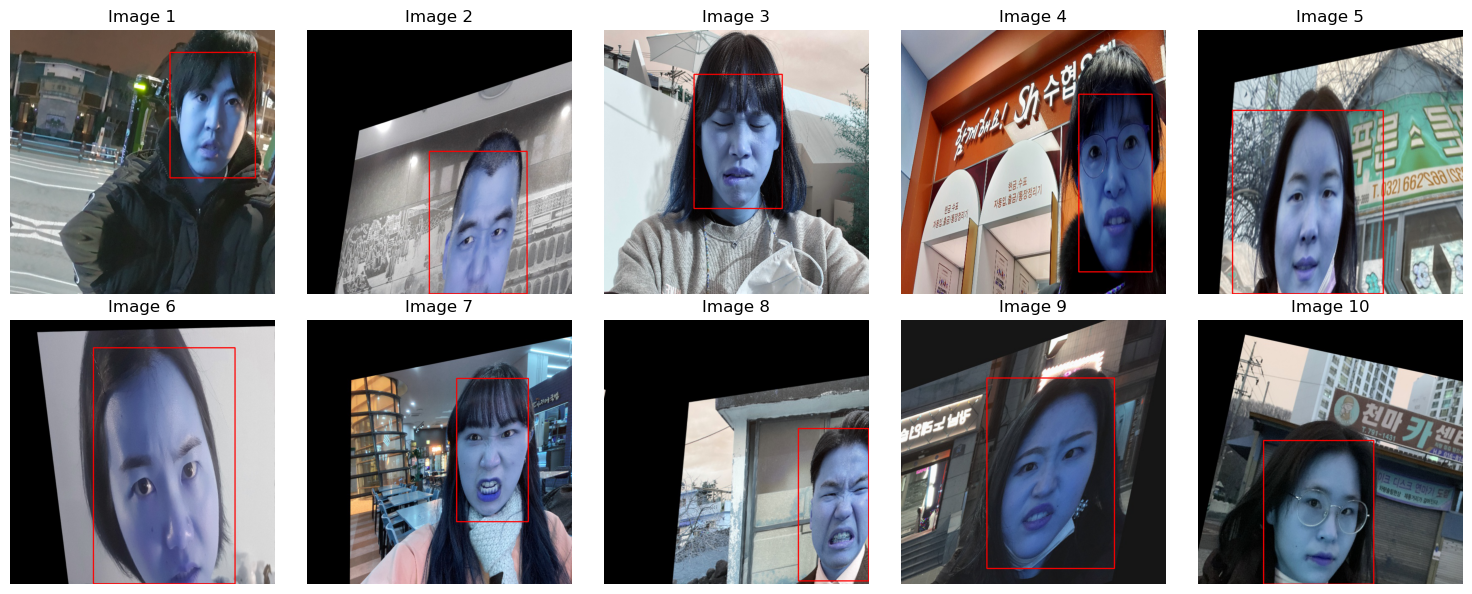

In [11]:
# 이미지와 바운딩 박스 시각화 (증강 데이터)
image_paths = []
boxes = []

for _, row in df_album.head(10).iterrows():
    img_file = row['filename']
    image_path = os.path.join(output_dir, img_file)
    image_paths.append(image_path)

    box_info = {
        'minX': int(row['minX']),
        'minY': int(row['minY']),
        'maxX': int(row['maxX']),
        'maxY': int(row['maxY']),
    }
    boxes.append(box_info)

# 시각화
visualize_images_with_boxes(image_paths, boxes)

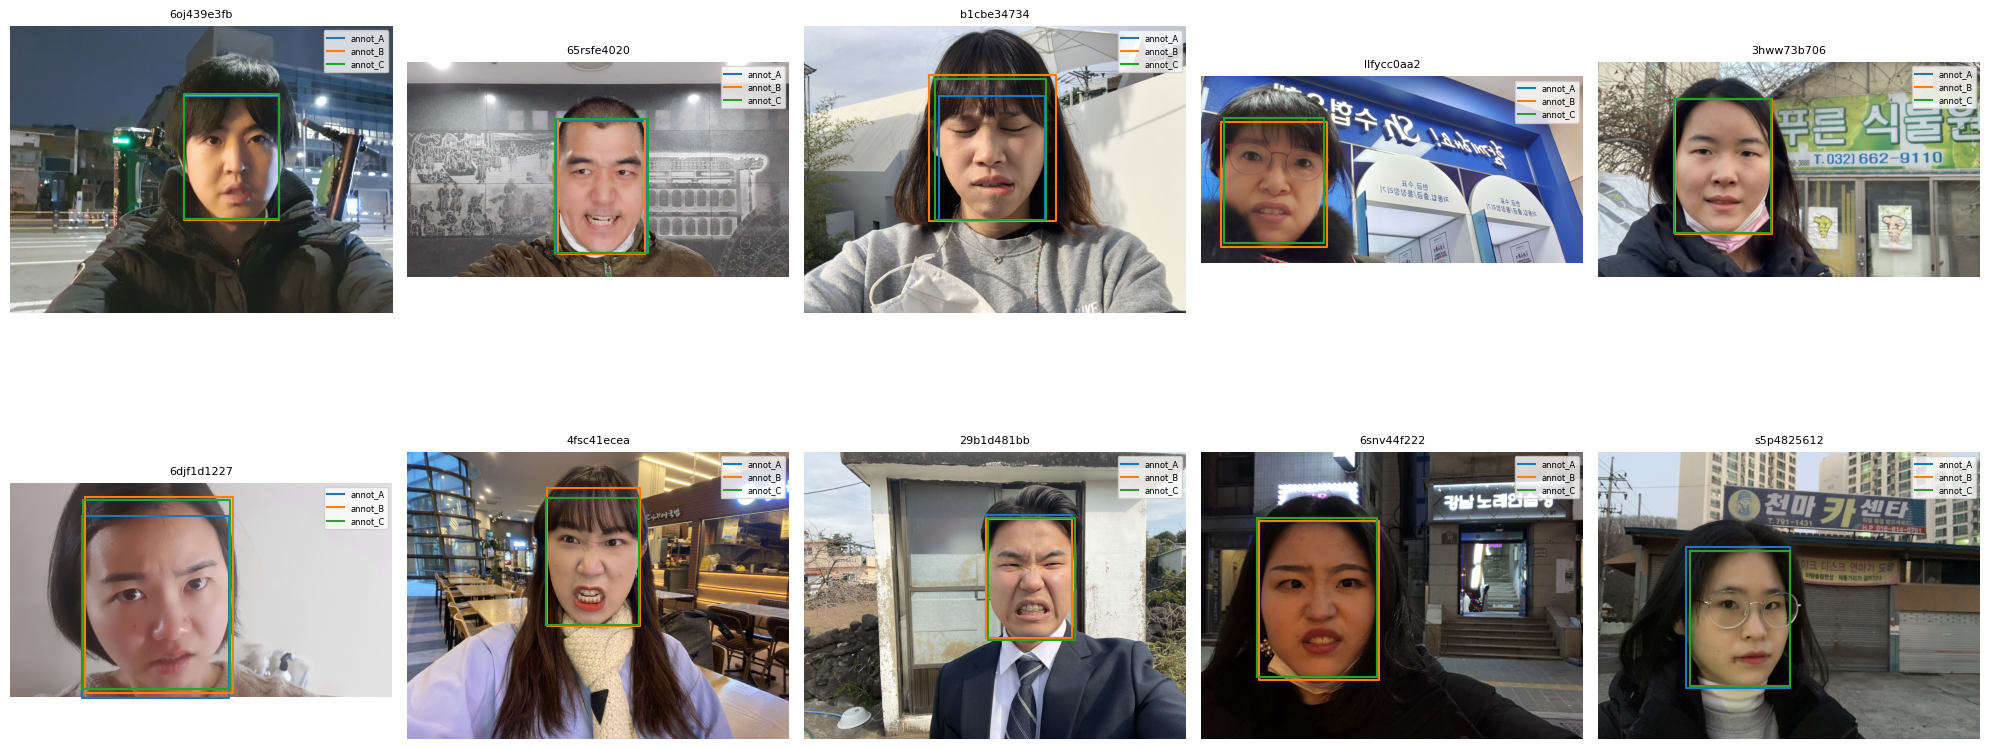

In [12]:
# 이미지와 바운딩 박스 시각화 (원본 데이터)

visualize_boxes(df, img_dir)